In [1]:
import os
import torch
import numpy as np
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as F
import random

In [2]:
torch.serialization.add_safe_globals([torchvision.models.detection.ssd.SSD])
model = torch.load('../src/model/ssd_calculator_merge_model4.1.10.pth', map_location='cpu',weights_only=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.head.classification_head.num_classes = 16
model.eval()

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

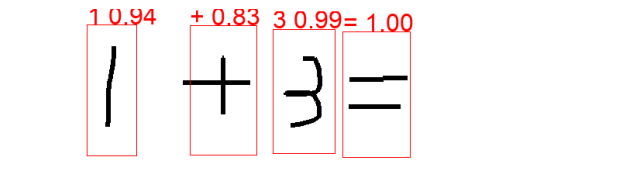

In [3]:
model.eval()
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

image_path = "sample_data/drawing_001.png" # ここに予測したい画像のパスを指定
orig_image = Image.open(image_path).convert("RGB")
input_tensor = transform(orig_image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(input_tensor)

output=outputs[0]

label_map = {
    1: '0', 2: '1', 3: '2', 4: '3', 5: '4',
    6: '5', 7: '6', 8: '7', 9: '8', 10: '9',
    11: '+', 12: '-', 13: '*', 14: '/', 15: '='
}

# ====== 7. 描画準備 ======
draw_image = orig_image.copy()
draw = ImageDraw.Draw(draw_image)

# スコアしきい値（信頼度）を設定
score_threshold = 0.5

# フォント（macOS用、必要に応じて変更）
try:
    font = ImageFont.truetype("Arial.ttf", 32)
except:
    font = ImageFont.load_default(32)

# ====== 8. 結果の描画 ======
boxes = output["boxes"]
labels = output["labels"]
scores = output["scores"]
orig_w, orig_h = orig_image.size
x_scale = orig_w / 300
y_scale = orig_h / 300
equation=[]
for box, label, score in zip(boxes, labels, scores):
    if score >= score_threshold:
        x1, y1, x2, y2 = box.tolist()
        x1 *= x_scale
        x2 *= x_scale
        y1 *= y_scale
        y2 *= y_scale
        label_name = label_map[int(label)]
        text = f"{label_name} {score:.2f}"
        equation.append([x1,label_name])
        # テキスト位置
        text_x = x1
        text_y = y1+10  # 少し上に出す
        text_size = draw.textlength(text, font=font)
        # draw.rectangle(
        #     [text_x, text_y, text_x + text_size, text_y + 35],
        #     fill="black"  # 背景色を指定
        # )
        draw.rectangle([x1, y1, x2, y2], outline="red", width=1)
        draw.text((x1, y1-30), f"{label_name} {score:.2f}", fill="red", font=font)
plt.figure(figsize=(8, 8))
plt.imshow(draw_image)
plt.axis("off")
plt.show()